In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random as rand

df = pd.read_csv("https://raw.githubusercontent.com/ConnorBruceUMBC/DS602_Midterm_Data/refs/heads/main/anomaly_detection.csv")
df.date = pd.to_datetime(df.date)

In [2]:
df.head()

,date,value,agency,anomaly
0,2020-01-01,197,AAA,0
1,2020-01-01,404,CCC,0
2,2020-01-01,153,BBB,0
3,2020-01-02,205,AAA,0
4,2020-01-02,401,CCC,0


In [3]:
df.isna().sum()

date       0
value      0
agency     0
anomaly    0
dtype: int64

# Data Visualizations

<Axes: xlabel='date', ylabel='value'>

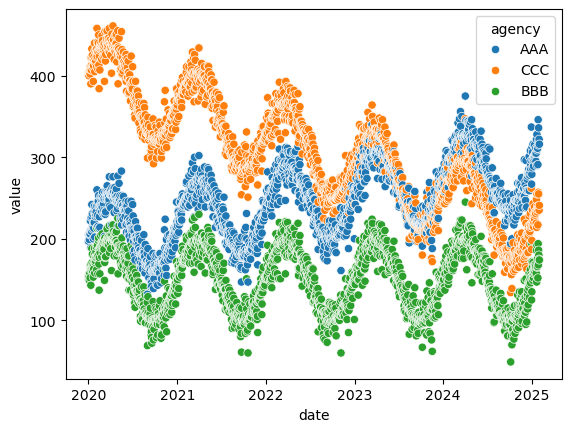

In [5]:
sns.scatterplot(data=df, x='date', y='value', hue='agency')

<Axes: xlabel='date', ylabel='value'>

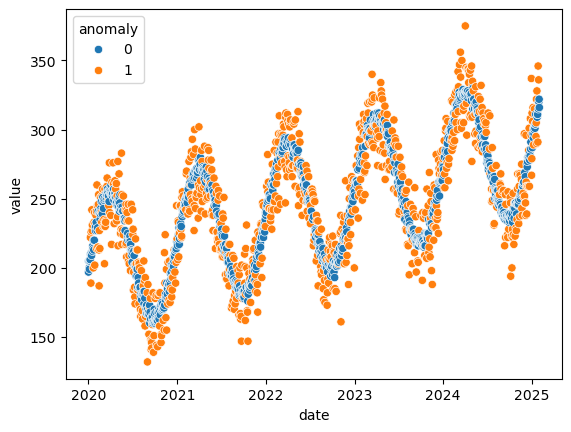

In [6]:
sns.scatterplot(data=df.query("agency=='AAA'"), x='date', y='value', hue='anomaly')

<Axes: xlabel='date', ylabel='value'>

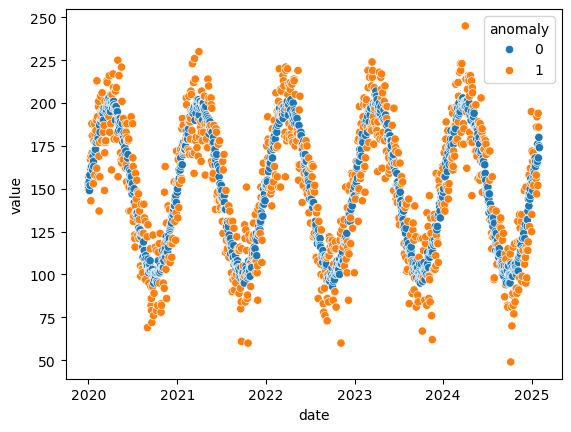

In [7]:
sns.scatterplot(data=df.query("agency=='BBB'"), x='date', y='value', hue='anomaly')

<Axes: xlabel='date', ylabel='value'>

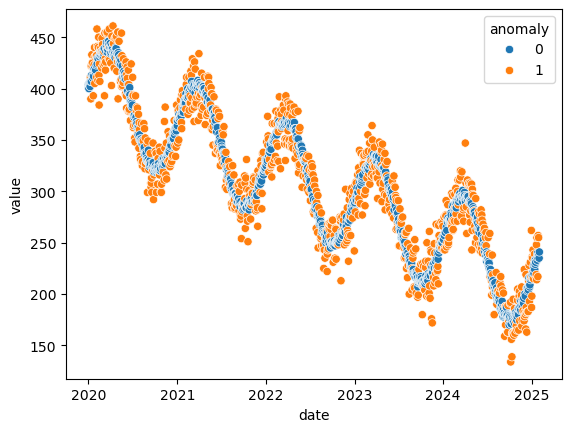

In [8]:
sns.scatterplot(data=df.query("agency=='CCC'"), x='date', y='value', hue='anomaly')

## Data Visualization Key Takeaways
- Agency will be a key factor in detecting anomalies. All agencies follow the same sin wave-like cycle with about a year between peaks, but there are some important distinctions. Agency 'AAA' increases on average year-to-year, 'BBB' stays consistent, and 'CCC' decreases.
- Since the the cycle of the data is yearly, features should be created to help the model capture this.
- To not be considered an anomaly, a point must fall within a narrow band. Therefore, small differences in how the model is behaving in terms of how a point relates to the points around it have a large effect. This should also be captured in the features.
- The data is time-series so the way that training and test data is selected should adhere to that (i.e. test data should be a continuous amount of time).
- The data only has 5-6 years, which is not many in the scope of building a model, therefore, it may be advantageous to take multiple training and testing sets to develop some models.

# Feature Engineering

#### Breaking down date
Pull out month, day and year

In [12]:
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['year'] = df['date'].dt.year
df.head()

,date,value,agency,anomaly,month,day,year
0,2020-01-01,197,AAA,0,1,1,2020
1,2020-01-01,404,CCC,0,1,1,2020
2,2020-01-01,153,BBB,0,1,1,2020
3,2020-01-02,205,AAA,0,1,2,2020
4,2020-01-02,401,CCC,0,1,2,2020


#### Total, Absolute, and Proportion from Previous Point
Large differences can indicate that one point may be an anomaly. These three ways of representing it gives the model multiple ways to interpret the difference.

In [14]:
df['tot_diff'] = df.groupby('agency')['value'].diff()
df.reset_index(drop=True)
df['abs_diff'] = df['tot_diff'].abs()
df['prop_of_prev'] = (df['value'])/(df['value']+df['tot_diff'])
df.head()

,date,value,agency,anomaly,month,day,year,tot_diff,abs_diff,prop_of_prev
0,2020-01-01,197,AAA,0,1,1,2020,NaN,NaN,NaN
1,2020-01-01,404,CCC,0,1,1,2020,NaN,NaN,NaN
2,2020-01-01,153,BBB,0,1,1,2020,NaN,NaN,NaN
3,2020-01-02,205,AAA,0,1,2,2020,8.0,8.0,0.962441
4,2020-01-02,401,CCC,0,1,2,2020,-3.0,3.0,1.007538


#### Day of Year
Since it appears that the value has a yearly cycle, the day of the year will be a useful feature. It is also important to add an indicator for if a year is a leap year so that the 366 day does not have an odd effect.

In [16]:
df['day_of_year']= df.groupby(['agency','year']).cumcount()+1
df.reset_index(drop=True)
df['leap_year'] = np.where(df['year']%4 == 0, 1, 0)
df.head()

,date,value,agency,anomaly,month,day,year,tot_diff,abs_diff,prop_of_prev,day_of_year,leap_year
0,2020-01-01,197,AAA,0,1,1,2020,NaN,NaN,NaN,1,1
1,2020-01-01,404,CCC,0,1,1,2020,NaN,NaN,NaN,1,1
2,2020-01-01,153,BBB,0,1,1,2020,NaN,NaN,NaN,1,1
3,2020-01-02,205,AAA,0,1,2,2020,8.0,8.0,0.962441,2,1
4,2020-01-02,401,CCC,0,1,2,2020,-3.0,3.0,1.007538,2,1


## Monthly Average and 7 day Rolling Average
When paired with the day of the month, the monthly average can help the model determine if a point differs from where it would expect it to be relative to the monthly average for that day of the specific month. The weekly rolling average can help do that on a smaller scale realtive to the points around it. The rolling average will be developed for both using the value as the end point and using the value as the midpoint. Note that this introduces a marginal amount of data leakage into the testing set as the monthly or weekly rolling average may span between sets. 

In [18]:
df['monthly_avg'] = df.groupby(['agency','month','year'])['value'].transform('mean').reset_index(drop=True)
df['weekly_roll_avg'] = df.groupby('agency')['value'].transform(lambda x: x.rolling(7,1).mean())
df['weekly_roll_avg_midpt'] = df.groupby('agency')['value'].transform(lambda x: x.rolling(7,1, center = True).mean())
df.head(n = 14)

,date,value,agency,anomaly,month,day,year,tot_diff,abs_diff,prop_of_prev,day_of_year,leap_year,monthly_avg,weekly_roll_avg,weekly_roll_avg_midpt
0,2020-01-01,197,AAA,0,1,1,2020,NaN,NaN,NaN,1,1,215.419355,197.000000,201.750000
1,2020-01-01,404,CCC,0,1,1,2020,NaN,NaN,NaN,1,1,412.290323,404.000000,402.500000
2,2020-01-01,153,BBB,0,1,1,2020,NaN,NaN,NaN,1,1,164.967742,153.000000,153.500000
3,2020-01-02,205,AAA,0,1,2,2020,8.0,8.0,0.962441,2,1,215.419355,201.000000,201.200000
4,2020-01-02,401,CCC,0,1,2,2020,-3.0,3.0,1.007538,2,1,412.290323,402.500000,402.800000
5,2020-01-02,150,BBB,0,1,2,2020,-3.0,3.0,1.020408,2,1,164.967742,151.500000,152.600000
6,2020-01-03,205,AAA,0,1,3,2020,0.0,0.0,1.000000,3,1,215.419355,202.333333,201.833333
7,2020-01-03,400,CCC,0,1,3,2020,-1.0,1.0,1.002506,3,1,412.290323,401.666667,403.166667
8,2020-01-03,157,BBB,0,1,3,2020,7.0,7.0,0.957317,3,1,164.967742,153.333333,153.500000
9,2020-01-04,200,AAA,0,1,4,2020,-5.0,5.0,1.025641,4,1,215.419355,201.750000,202.428571


## Proportion to Weekly Average

In [20]:
df['weekly_avg_prop'] = df['value']/df['weekly_roll_avg_midpt']
df.head()

,date,value,agency,anomaly,month,day,year,tot_diff,abs_diff,prop_of_prev,day_of_year,leap_year,monthly_avg,weekly_roll_avg,weekly_roll_avg_midpt,weekly_avg_prop
0,2020-01-01,197,AAA,0,1,1,2020,NaN,NaN,NaN,1,1,215.419355,197.0,201.75,0.976456
1,2020-01-01,404,CCC,0,1,1,2020,NaN,NaN,NaN,1,1,412.290323,404.0,402.50,1.003727
2,2020-01-01,153,BBB,0,1,1,2020,NaN,NaN,NaN,1,1,164.967742,153.0,153.50,0.996743
3,2020-01-02,205,AAA,0,1,2,2020,8.0,8.0,0.962441,2,1,215.419355,201.0,201.20,1.018887
4,2020-01-02,401,CCC,0,1,2,2020,-3.0,3.0,1.007538,2,1,412.290323,402.5,402.80,0.995531


In [21]:
df = df.fillna(0)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   date                   5574 non-null   datetime64[ns]
 1   value                  5574 non-null   int64         
 2   agency                 5574 non-null   object        
 3   anomaly                5574 non-null   int64         
 4   month                  5574 non-null   int32         
 5   day                    5574 non-null   int32         
 6   year                   5574 non-null   int32         
 7   tot_diff               5574 non-null   float64       
 8   abs_diff               5574 non-null   float64       
 9   prop_of_prev           5574 non-null   float64       
 10  day_of_year            5574 non-null   int64         
 11  leap_year              5574 non-null   int64         
 12  monthly_avg            5574 non-null   float64       
 13  wee

## Variable Selection
- <b>value</b>: This is the primary field being used to predict anomalies.
- <b>agency</b>: The trends are clearly distinct between agencies. This is true of both the values and the trend. When paired with the year, the model can help keep track of the general trend of each agency.
- <b>month, day, year</b>: Breaking down the date into its components lets the model make predictions based on the individual values as opposed to being limited to the date as a whole. Month will be treated as categorical while day and year will be treated as numeric.
- <b>tot_diff, prop_of_prev</b>: Large jumps can indicate anomalous behavior. We are keeping this over absolute difference because it provides more information (positive/negative change). By pairing the total difference with the proportional difference, we hope the model is able to detect large changes in both magnitude and relative to nearby values.
- <b>day_of_year, leap_year</b>: Since the daya has clear seasonaility based on the time of the year, day of the year is a good way to represent where the data is in its yearly cycle Leap year can help reduce odd effects of having a 366th day and will be treated as a categorical variable.
- <b>weekly_roll_avg_midpt, weekly_avg_prop</b>: This can be used to determine whether a value is distinctly different than the values around it. We are choosing midpoint over having the value be the tail end of the rolling average because it takes into account both past and future data. By pairing this with the proportional difference, we hope the model is able to detect large changes in both magnitude and relative to nearby values.


# Model Development

In [24]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate

## Categorical vs. Numeric Variables

In [26]:
cat_vars = ['agency','leap_year','month']
num_vars = ['value','day','year','tot_diff','prop_of_prev','day_of_year','weekly_roll_avg_midpt','weekly_avg_prop']
pred_var = ['anomaly']

# Test and Train Sets
Splitting into test and train sets is different for time-series variables as the test set must be a continuous amount of time. To simulate this, we will take a random number between 0 and 0.8*number of rows-1. This is so we can split the data from the random number generated, n, to n + test_size to get a proportion of continuous data equal to the test size. The preceeding graphs show how the test set is cut from the data.

In [28]:
test_prop = 0.2
df_rows = len(df)
test_size = round(df_rows*test_prop)
max_rn = df_rows-test_size-1
print("No. Rows:",df_rows,"| Test Size :",test_size,"| Max RN:",max_rn)

No. Rows: 5574 | Test Size : 1115 | Max RN: 4458


In [29]:
test_rn = rand.randint(0, max_rn)
test_end = test_rn + test_size
X_test = df[test_rn:test_end][cat_vars+num_vars]
y_test = df[test_rn:test_end]['anomaly']
X_train = df.drop(index=range(test_rn,test_end+1))[cat_vars+num_vars]
y_train = df.drop(index=range(test_rn,test_end+1))['anomaly']
X_test.shape,y_test.shape,X_train.shape,y_train.shape

((1115, 11), (1115,), (4458, 11), (4458,))

<Axes: xlabel='date', ylabel='value'>

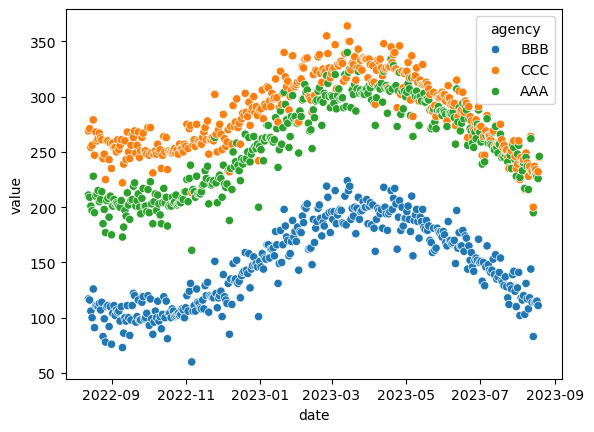

In [30]:
X_test_date = df[test_rn:test_end][cat_vars+num_vars+['date']]
sns.scatterplot(data=X_test_date, x='date', y='value', hue='agency')

<Axes: xlabel='date', ylabel='value'>

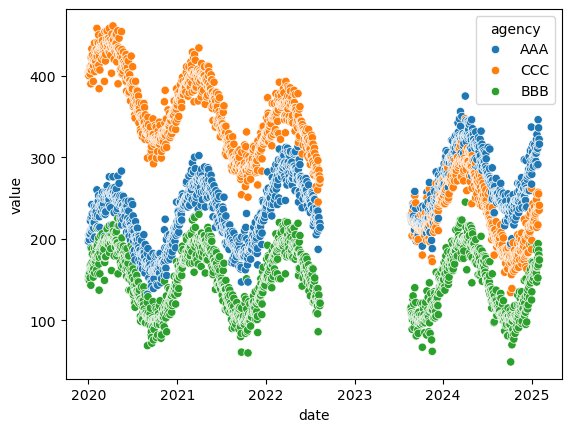

In [31]:
X_train_date = df.drop(index=range(test_rn,test_end+1))[cat_vars+num_vars+['date']]
sns.scatterplot(data=X_train_date, x='date', y='value', hue='agency')

Now that we know that the process works, we can turn it into a function to make it easier/quicker to run.

In [33]:
def ts_test_train_split(df=df,test_prop=.2, cat_vars=cat_vars, num_vars=num_vars, pred_var=pred_var):
    df_rows = len(df)
    test_size = round(df_rows*test_prop)
    max_rn = df_rows-test_size-1
    test_rn = rand.randint(0, max_rn)
    test_end = test_rn + test_size
    X_test = df[test_rn:test_end][cat_vars+num_vars]
    y_test = df[test_rn:test_end][pred_var]
    X_train = df.drop(index=range(test_rn,test_end+1))[cat_vars+num_vars]
    y_train = df.drop(index=range(test_rn,test_end+1))[pred_var]
    return X_test,y_test,X_train,y_train

In [34]:
X_test,y_test,X_train,y_train = ts_test_train_split(test_prop = 0.20)

X_test.shape,y_test.shape,X_train.shape,y_train.shape

((1115, 11), (1115, 1), (4458, 11), (4458, 1))

## Logistic Regression Model
The first model we will test is the Logistic Regression model. Because the linearity of the features is not inherently clear, this model may struggle. We will test it first using cross-validation and grid searching to tune the hyper parameters. Next we will do the same process, but include PCA in the processing.

In [36]:
log_reg_processing_pipeline = ColumnTransformer(transformers=[
    ('numscaling', StandardScaler(), num_vars),
    ('dummys', OneHotEncoder(drop='first'), cat_vars)]
)

log_reg_modeling_pipeline = Pipeline([
        ('data_processing', log_reg_processing_pipeline),
        ('logreg', LogisticRegression())]
    )
log_reg_param_grid = [
  {'logreg__class_weight': [None, 'balanced'], 
   'logreg__C':[0.01, 0.1, 1, 10, 100]}
 ]

log_reg_results = GridSearchCV(estimator=log_reg_modeling_pipeline, 
                           param_grid=log_reg_param_grid, scoring='f1', refit=True)
log_reg_results = log_reg_results.fit(X_train, y_train.values.ravel())

log_reg_results.best_estimator_

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('numscaling',
                                                  StandardScaler(),
                                                  ['value', 'day', 'year',
                                                   'tot_diff', 'prop_of_prev',
                                                   'day_of_year',
                                                   'weekly_roll_avg_midpt',
                                                   'weekly_avg_prop']),
                                                 ('dummys',
                                                  OneHotEncoder(drop='first'),
                                                  ['agency', 'leap_year',
                                                   'month'])])),
                ('logreg', LogisticRegression(C=100, class_weight='balanced'))])

In [37]:
y_testp_lr = log_reg_results.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_testp_lr))

              precision    recall  f1-score   support

           0       0.61      0.57      0.59       587
           1       0.56      0.60      0.58       528

    accuracy                           0.58      1115
   macro avg       0.59      0.59      0.58      1115
weighted avg       0.59      0.58      0.58      1115



In [38]:
pca_modeling_pipeline = Pipeline([
            ('data_processing',log_reg_processing_pipeline),
            ('pca', PCA(n_components=4)),
            ('model', LogisticRegression())
        ])


pca_log_reg_results = GridSearchCV(estimator=pca_modeling_pipeline, 
                           param_grid=log_reg_param_grid, scoring='f1', refit=True)
pca_log_reg_results = log_reg_results.fit(X_train, y_train.values.ravel())

pca_log_reg_results.best_estimator_

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('numscaling',
                                                  StandardScaler(),
                                                  ['value', 'day', 'year',
                                                   'tot_diff', 'prop_of_prev',
                                                   'day_of_year',
                                                   'weekly_roll_avg_midpt',
                                                   'weekly_avg_prop']),
                                                 ('dummys',
                                                  OneHotEncoder(drop='first'),
                                                  ['agency', 'leap_year',
                                                   'month'])])),
                ('logreg', LogisticRegression(C=100, class_weight='balanced'))])

In [39]:
y_testp_lr_pca = pca_log_reg_results.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_testp_lr_pca))

              precision    recall  f1-score   support

           0       0.61      0.57      0.59       587
           1       0.56      0.60      0.58       528

    accuracy                           0.58      1115
   macro avg       0.59      0.59      0.58      1115
weighted avg       0.59      0.58      0.58      1115



### Logistic Regression Results
Based on the results, we do not see large differences in whether the logistic regression processing pipeline utilized principal compenent analysis. In either case, the accuracy is not up to par, hovering around the mid 50's. Because of this, we will look to different modeling methods for predicting whether a value is an anomaly.

## Random Forest Model
A random forest model will likely be a better fit for the data being modeled because of the non-linearity of the data. Again, similar tot he logistic regression, we will use PCA when processing the data. Additionally, we will be using a grid search to select the optimal hyperparameters.

In [42]:
rf_processing_pipeline = ColumnTransformer(transformers=[
    ('numscaling', StandardScaler(), num_vars),
    ('dummys', OneHotEncoder(drop='first'), cat_vars)]
)

rf_pipeline = Pipeline([
    ('data_processing', rf_processing_pipeline),
    ('rf', RandomForestClassifier())]
)

rf_param_grid = [{'rf__max_depth': [5, 8, 10, 12],
               'rf__n_estimators': [10, 50, 100],
               'rf__class_weight': [None, 'balanced', 'balanced_subsample'],
               'rf__max_samples': [1000, 2000, 3000]
              }]

rf_results = GridSearchCV(estimator=rf_pipeline, param_grid=rf_param_grid, scoring='f1', refit=True)
rf_results = rf_results.fit(X_train, y_train.values.ravel())
rf_yhat = rf_results.predict(X_test)

rf_results.best_estimator_

Pipeline(steps=[('data_processing',
                 ColumnTransformer(transformers=[('numscaling',
                                                  StandardScaler(),
                                                  ['value', 'day', 'year',
                                                   'tot_diff', 'prop_of_prev',
                                                   'day_of_year',
                                                   'weekly_roll_avg_midpt',
                                                   'weekly_avg_prop']),
                                                 ('dummys',
                                                  OneHotEncoder(drop='first'),
                                                  ['agency', 'leap_year',
                                                   'month'])])),
                ('rf',
                 RandomForestClassifier(class_weight='balanced', max_depth=12,
                                        max_samples=3000, n_estimators=50))])

In [43]:
y_testp_rf = rf_results.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_testp_rf))

              precision    recall  f1-score   support

           0       0.79      0.92      0.85       587
           1       0.89      0.73      0.80       528

    accuracy                           0.83      1115
   macro avg       0.84      0.82      0.82      1115
weighted avg       0.84      0.83      0.82      1115



### Feature Importance for RF Model

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


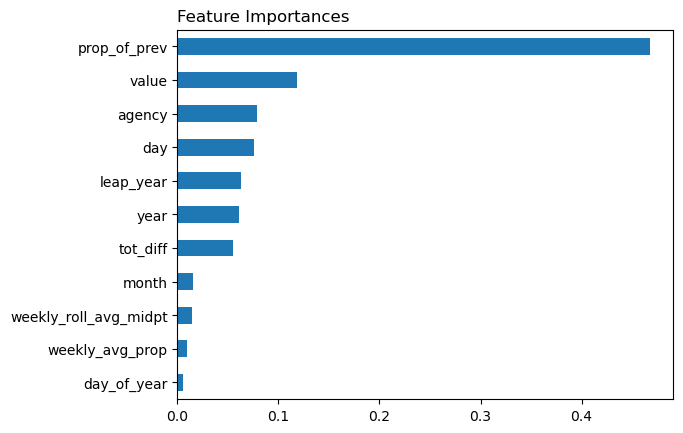

In [45]:
rf_imp_mod_pipeline = Pipeline([
    ('data_processing', rf_processing_pipeline),
    ('rf', RandomForestClassifier(n_estimators=50,max_samples = 3000, max_depth = 12))]
)

rf_imp_mod_pipeline.fit(X_train,y_train)

imps = list(zip(df[cat_vars+num_vars], rf_imp_mod_pipeline[1][1].feature_importances_))

fi = pd.Series([x[1] for x in imps], index=[x[0] for x in imps])
fi = fi.sort_values(ascending=True)

fi.plot.barh()
plt.title('Feature Importances', loc='left')
plt.show()

### Random Forest Results
The random forest model performed much better than the logistic regression model, getting an accuracy in the mid 80s, and f1 scores of .86 and .81 respectively for non-anomalies and anomalies. From the feature importance, we can see that the proprtion of previous carried the most weight followed by day and agency. This most likely means that the model looked for large differences day-over-day as a key indicator whether a value was considered an anomaly. The day may have been important because the model identified general trends throughout a given month and used that trend to determine if a value was out of line.

## Isolation Forest Model

In [48]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import numpy as np

In [49]:
df = pd.read_csv("anomaly_detection.csv")
df['date'] = pd.to_datetime(df['date'])

In [50]:
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['day_of_year'] = df['date'].dt.dayofyear
df['leap_year'] = df['year'].apply(lambda y: 1 if ((y % 4 == 0 and y % 100 != 0) or (y % 400 == 0)) else 0)

In [51]:
df = df.sort_values(['agency', 'date'])

df['tot_diff'] = df.groupby('agency')['value'].diff()
df['prop_of_prev'] = df['tot_diff'] / df.groupby('agency')['value'].shift(1)

df['weekly_roll_avg_midpt'] = df.groupby('agency')['value'].rolling(window=7, center=True, min_periods=1).mean().reset_index(level=0, drop=True)
df['weekly_avg_prop'] = df['value'] / df['weekly_roll_avg_midpt']

In [52]:
cat_vars = ['agency', 'leap_year', 'month']
num_vars = ['value', 'day', 'year', 'tot_diff', 'prop_of_prev', 'day_of_year', 'weekly_roll_avg_midpt', 'weekly_avg_prop']
pred_var = ['anomaly']

# Encode categorical variables
label_encoder = LabelEncoder()
df['agency_encoded'] = label_encoder.fit_transform(df['agency'])

# Combine feature columns
features = df[['agency_encoded', 'leap_year', 'month'] + num_vars]

# Replace any infinities and NaNs from division
features = features.replace([np.inf, -np.inf], np.nan).fillna(0)

In [53]:
iso_model = IsolationForest(contamination=0.05, random_state=42)
df['predicted_anomaly'] = iso_model.fit_predict(features)

# Convert prediction: -1 = anomaly, 1 = normal → 1 = anomaly, 0 = normal
df['predicted_anomaly'] = df['predicted_anomaly'].map({1: 0, -1: 1})

In [54]:
y_true = df['anomaly']
y_pred = df['predicted_anomaly']

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(y_true, y_pred))

Confusion Matrix:
[[2994   51]
 [2301  228]]

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.98      0.72      3045
           1       0.82      0.09      0.16      2529

    accuracy                           0.58      5574
   macro avg       0.69      0.54      0.44      5574
weighted avg       0.68      0.58      0.47      5574



# Key Takeaways/Learnings
- For this particular problem, the random forest model was superior to the logistic regression model.
- A testing set size of 20% was chosen because there are roughly 5 years worth of data, and a continuous 20% includes an entire year. 
- Using hyperparameter grids, we allowed the model to select the ideal hyperparameters. When developing the list of values that went into the grid, testing was done to determine the range of values that was included based on running the program multiple times with different values.
- For logistic regression, pca did not have a large effect. This could be due to the fact that logistic regression was simply not a good way to model this problem due to the lack of linear features.
- Feature engineering is critical for not just this dataset, but many datasets when it comes to building a model.
- Some features developed during feature engineering may simply be used to develop another feature, or may be entirely excluded from the modeling process if it does not bring value or skews results.
- For this dataset, the strongest engineered feature involved comparing a value to its previous value.
- Other important engineered features included whether a year was a leap year and the different components of the date.
- As expected, the agency was also an important feature due to the fact that each agency had a distinct trend.
- The model is slightly better at predicting when something is NOT an anomaly as shown by the f1 scores.
- day of year was suprisingly not an important feature, this may be due to there only being 4 years worth of data within the training set so the model did not prioritize comparing values for a given day of the year.
